In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
##Data Aquisition
me_test = np.load('LO_3_MG/3Jet_500000.npy', allow_pickle=True) #Matrix elements - test
momentum_test_r = np.load('LO_3_0.01_NJet/PS3_0.01_500000.npy', allow_pickle=True, encoding='bytes')#4-momenta of inputs - test
momentum_test_r = np.array([np.array(element) for element in momentum_test_r])

me_train = np.load('LO_3_MG/3Jet_3000000.npy', allow_pickle=True) #Matrix elements - train
momentum_train_r = np.load('LO_3_0.01_NJet/PS3_0.01_3000000.npy', allow_pickle=True, encoding='bytes') #4-momenta of input - train
momentum_train_r = np.array([np.array(element) for element in momentum_train_r])

Adding some extra features

In [3]:
##Minkowski product of 4-vectors p1, p2.
def m_prod_arr(p1, p2):
    #Input: p1, p2 - n x 4 dimensional numpy array.
    #Output: n dimensional numpy array.
    return np.multiply(p1[:,0], p2[:,0]) - np.sum(np.multiply(p1[:,1:], p2[:,1:]), axis=1)

In [4]:
p_12tr = np.sum(np.array(momentum_train_r)[:,2:4], axis=1) #p1+p2
p_13tr = np.sum(np.array(momentum_train_r)[:,2:5:2], axis=1) #p1+p3
p_23tr = np.sum(np.array(momentum_train_r)[:,3:5], axis=1) #p2+p3

p_12te = np.sum(np.array(momentum_test_r)[:,2:4], axis=1) #p1+p2
p_13te = np.sum(np.array(momentum_test_r)[:,2:5:2], axis=1) #p1+p3
p_23te = np.sum(np.array(momentum_test_r)[:,3:5], axis=1) #p2+p3

s_12tr = m_prod_arr(p_12tr, p_12tr) #center of mass energyies of two of three beams
s_13tr = m_prod_arr(p_13tr, p_13tr)
s_23tr = m_prod_arr(p_23tr, p_23tr)

s_12te = m_prod_arr(p_12te, p_12te)
s_13te = m_prod_arr(p_13te, p_13te)
s_23te = m_prod_arr(p_23te, p_23te)

#Dot product with incoming particle
ang_1tr = momentum_train_r[:,2,3]/momentum_train_r[:,2,0]
ang_2tr = momentum_train_r[:,3,3]/momentum_train_r[:,3,0]

ang_1te = momentum_test_r[:,2,3]/momentum_test_r[:,2,0]
ang_2te = momentum_test_r[:,3,3]/momentum_test_r[:,3,0]

In [14]:
##Reformat Momentum
momentum_train = np.array([np.ndarray.flatten(np.array(element)[3:]) for element in momentum_train_r])
momentum_test = np.array([np.ndarray.flatten(np.array(element)[3:]) for element in momentum_test_r])

##Add extra features
momentum_train = np.hstack((momentum_train, s_23tr[:,None], s_12tr[:,None], s_13tr[:,None], ang_2tr[:,None]))
momentum_test = np.hstack((momentum_test, s_23te[:,None], s_12te[:,None], s_13te[:,None], ang_2te[:,None]))

##Data transformation
pipeline = Pipeline([
    ('scaler', StandardScaler()), #Rescale Data.
    ('kbins', KBinsDiscretizer(n_bins=200)) #Checking convergence as bins.
])
 
momentum_train = pipeline.fit_transform(momentum_train) #Rescale on training set
momentum_test = pipeline.transform(momentum_test) #Rescale on test set

In [15]:
linreg = LinearRegression().fit(momentum_train, me_train)

me_predict_lin = linreg.predict(momentum_test) #Prediction on test set
lin_mse = mean_squared_error(me_test, me_predict_lin) 
print(np.sqrt(lin_mse))

lin_perc = 100*np.abs(me_test[10] - me_predict_lin[10])/me_test[10]
print(lin_perc)

1.0150097331014477e-05
30.58303022996773


## Plotting Learning Curve

In [ ]:
##Plotting a Learning Curve
split = StratifiedShuffleSplit() #Collects data evenly about mean to put into validation sets
train = split.split(momentum_train, pd.cut(me_train, bins = 100)) #But are we testing on something we've trained..?

train_sizes, train_scores, test_scores = learning_curve(
        linreg, momentum_train, me_train, scoring='neg_mean_squared_error',
        cv=5, shuffle=True, train_sizes=np.linspace(0.001, 0.01, 5), 
        n_jobs=1, verbose=1)

In [ ]:
pyplot.figure()

train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

pyplot.xlabel("Training examples")
pyplot.ylabel("Score")
pyplot.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
pyplot.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

pyplot.legend(loc="best")

In [ ]:
np.std(me_test)

## Plot accuracy vs number of bins

In [11]:
def changeBins(n_bins, input_train, input_test, output_train, output_test):
    ##Data transformation
    pipeline = Pipeline([
        ('scaler', StandardScaler()), #Rescale Data.
        ('kbins', KBinsDiscretizer(n_bins=n_bins)) #Checking convergence as bins.
    ])

    input_train = pipeline.fit_transform(input_train) #Rescale on training set
    input_test = pipeline.transform(input_test) #Rescale on test set
    
    linreg = LinearRegression().fit(input_train, output_train)

    me_predict_lin = linreg.predict(input_test) #Prediction on test set
    lin_mse = mean_squared_error(output_test, me_predict_lin) 
    
    return np.sqrt(lin_mse)

In [12]:
##Reformat Momentum
momentum_train = np.array([np.ndarray.flatten(np.array(element)[3:, 1:]) for element in momentum_train_r])
momentum_test = np.array([np.ndarray.flatten(np.array(element)[3:, 1:]) for element in momentum_test_r])

##Add extra features
momentum_train = np.hstack((momentum_train, s_23tr[:,None], s_12tr[:,None], s_13tr[:,None], ang_1tr[:,None]))
momentum_test = np.hstack((momentum_test, s_23te[:,None], s_12te[:,None], s_13te[:,None], ang_1te[:,None]))

n_bins_arr = range(10, 300, 50)
result = []
for n_bins in n_bins_arr:
    print(changeBins(n_bins, momentum_train, momentum_test, me_train, me_test))
    result.append(changeBins(n_bins, momentum_train, momentum_test, me_train, me_test))


1.5584746445016632e-05
1.249174248577123e-05
1.1340337668592377e-05
1.0610135385865848e-05
1.0062787147708835e-05
9.631533095296508e-06


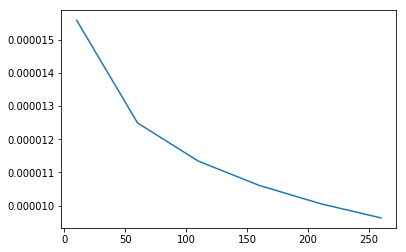

In [13]:
pyplot.plot(n_bins_arr, result)

In [ ]:
print(np.mean(me_test))